In [2]:
pip install pyglmnet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
Note: This project is incomplete. I realized my standard errors are underestimated because of serial correlation
of errors when I do cross sectional regressions. To fix it, i will update this 
code to implement the regressions in the style of Fama-MacBeth regressions.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy import stats
from pyglmnet import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

# just some cleaning
excess_returns_df = pd.read_csv("/Users/vedant/Desktop/Yale class things/Stats/PSET3/stock_returns_extended.csv")
excess_returns_df = excess_returns_df.set_index("eom")
excess_returns_df = excess_returns_df.dropna()
# Move column 'r' to the front
cols = ['r'] + [col for col in excess_returns_df.columns if col != 'r']
excess_returns_df = excess_returns_df[cols]
cols = ['permno'] + [col for col in excess_returns_df.columns if col != 'permno']
excess_returns_df = excess_returns_df[cols]
excess_returns_df = excess_returns_df.sort_values(by=['eom',"permno"])
excess_returns_df['permno'] = excess_returns_df['permno'].astype(int)
# Ensure return and market equity columns are float
return_cols = [col for col in excess_returns_df.columns if 'ret' in col or 'me' in col]
excess_returns_df[return_cols] = excess_returns_df[return_cols].astype(float)
excess_returns_df.isnull().sum()
excess_returns_df.iloc[:, -12:] = excess_returns_df.iloc[:, -12:] * 100
excess_returns_df

,permno,r,me_lg1,r_lg1,r_lg2,r_lg3,r_lg4,r_lg5,r_lg6,r_lg7,r_lg8,r_lg9,r_lg10,r_lg11,r_lg12
eom,,,,,,,,,,,,,,,
1951-01-31,10030,0.056063,43.018000,15.928462,-0.105100,3.233705,-1.085507,5.805378,16.030632,-7.789208,5.298606,-1.979739,0.659280,-3.010208,2.140006
1951-01-31,10065,0.062777,33.977125,7.703933,4.759765,3.229955,5.130658,4.780649,0.515097,-9.932966,2.702189,1.628486,2.814377,-0.668535,-3.987689
1951-01-31,10102,0.107829,75.240000,0.249860,9.795890,2.908303,1.959956,1.473281,13.431012,-10.623216,-1.148467,9.518720,-2.302545,-2.778672,1.540544
1951-01-31,10137,0.035604,86.800000,6.652785,4.440355,0.898408,1.734835,8.189893,-2.786572,-10.239080,4.868324,-2.037019,-3.518526,3.755654,8.801724
1951-01-31,10145,0.024162,522.504000,3.308304,7.481107,-5.143834,-1.225496,6.095782,-4.446226,-9.116508,8.403838,8.209131,6.736668,-0.575937,0.389005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,93145,0.021983,21155.737731,2.652785,-1.332394,-2.099712,-0.611705,-0.527065,-1.619359,-1.424110,0.360819,2.698986,-2.780941,2.026280,-1.067017
2023-12-31,93147,0.007297,22185.209950,0.608107,-0.126360,-0.540811,0.015469,-0.147047,-0.885277,-0.751983,-0.137321,1.318645,-1.092299,0.393088,-0.177732
2023-12-31,93182,0.039556,21527.819587,10.699732,-1.984149,-5.704347,-1.407305,3.096593,6.363968,6.005829,1.017006,7.816735,-1.589273,9.584605,-8.557593


In [5]:
train = excess_returns_df[excess_returns_df.index < '2000-01-01']
test = excess_returns_df[excess_returns_df.index >= '2000-01-01']

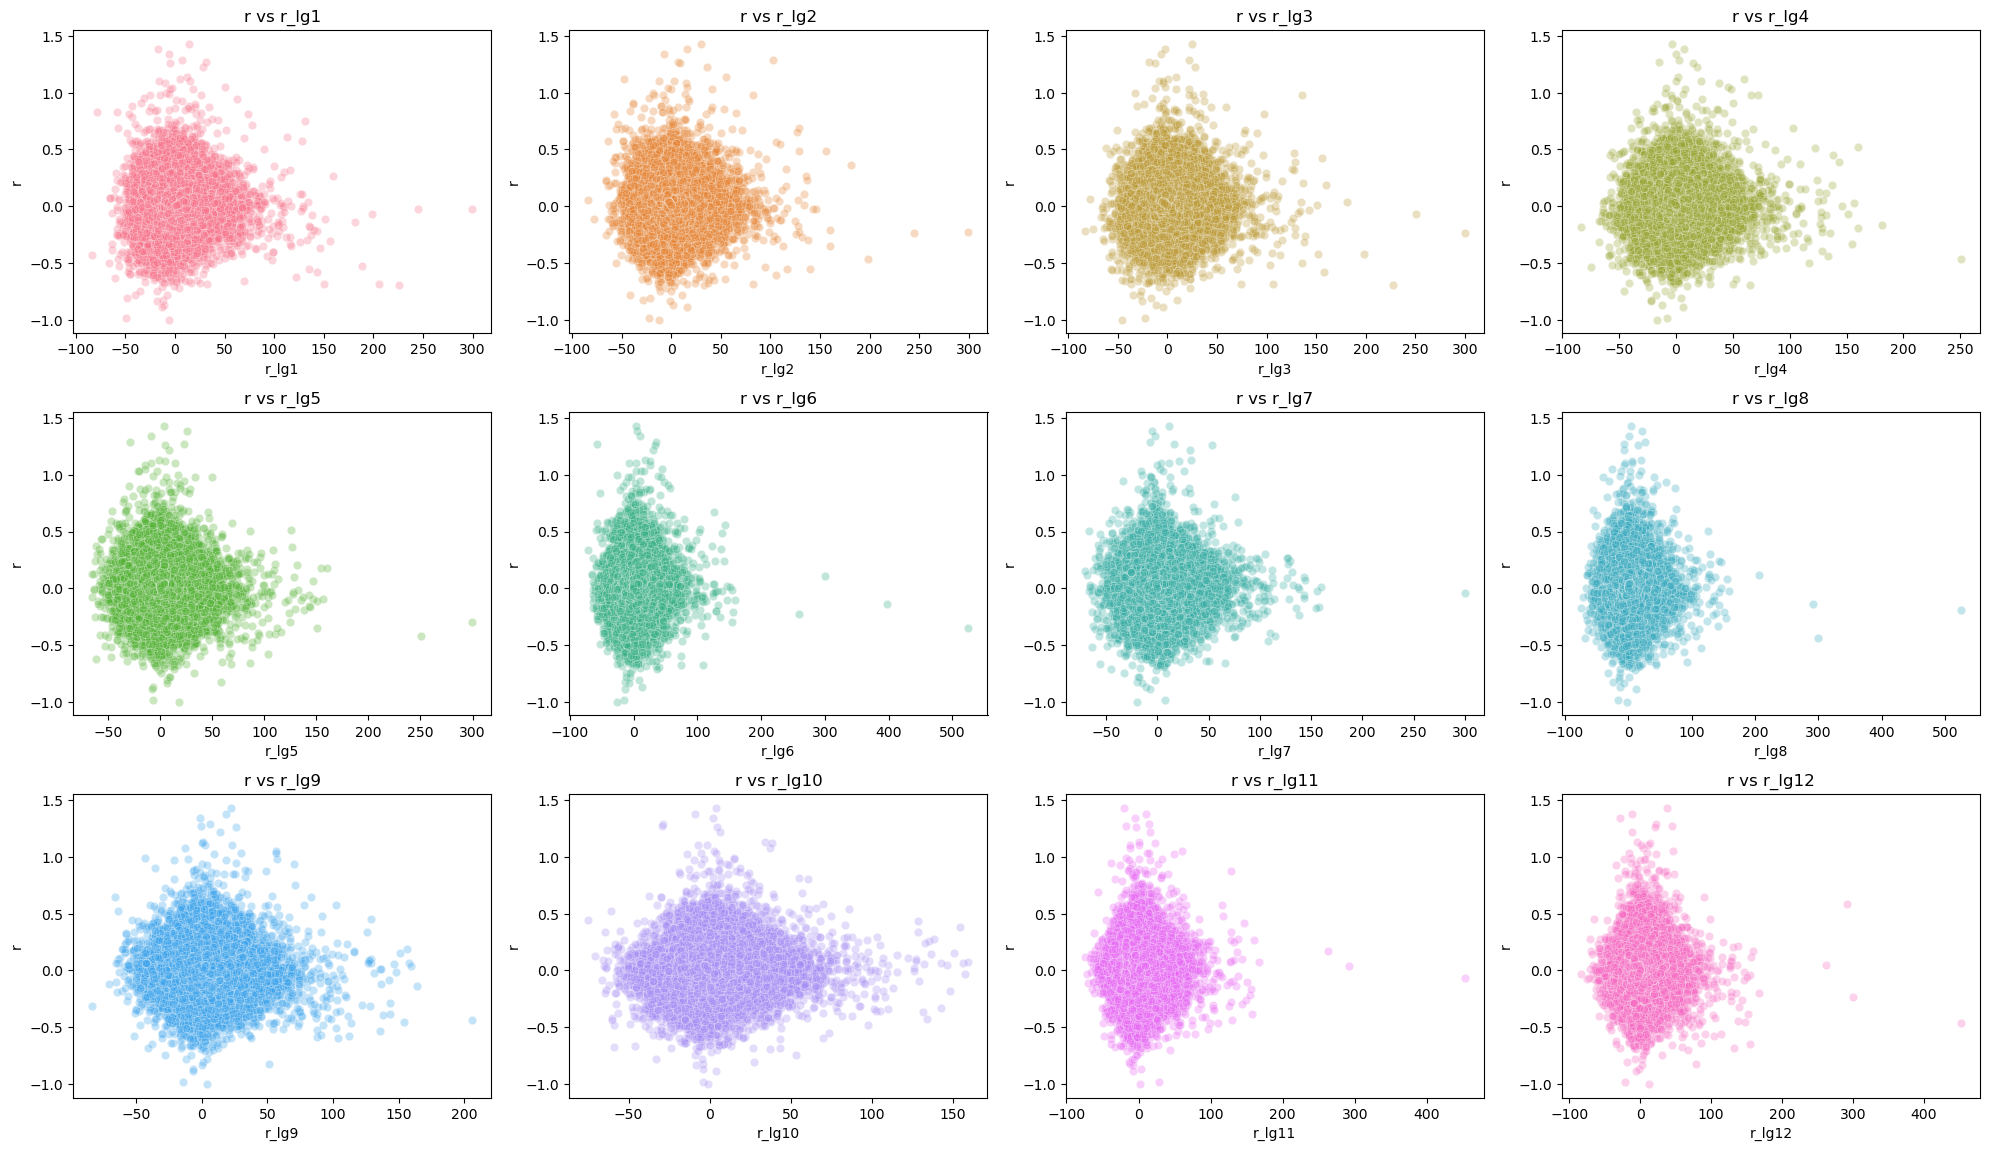

In [6]:
# 1) Look for non linearity and do data transformations

# 1. Define Explanatory Variables
explanatory_vars = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg5',
                    'r_lg6', 'r_lg7', 'r_lg8', 'r_lg9', 'r_lg10',
                    'r_lg11', 'r_lg12']
# 2. Scatter Plots to Check for Non-Linearity
# 2. Generate a Distinct Color Palette
num_vars = len(explanatory_vars)
palette = sns.color_palette("husl", num_vars)  # "husl" provides a good distribution of colors

# 3. Scatter Plots to Check for Non-Linearity with Distinct Colors
plt.figure(figsize=(20, 15))
for i, (var, color) in enumerate(zip(explanatory_vars, palette), 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(
        x=excess_returns_df[var],
        y=excess_returns_df['r'],
        color=color,
        alpha=0.3
    )
    plt.title(f'r vs {var}', fontsize=12)
    plt.xlabel(var, fontsize=10)
    plt.ylabel('r', fontsize=10)
plt.tight_layout()
plt.show()


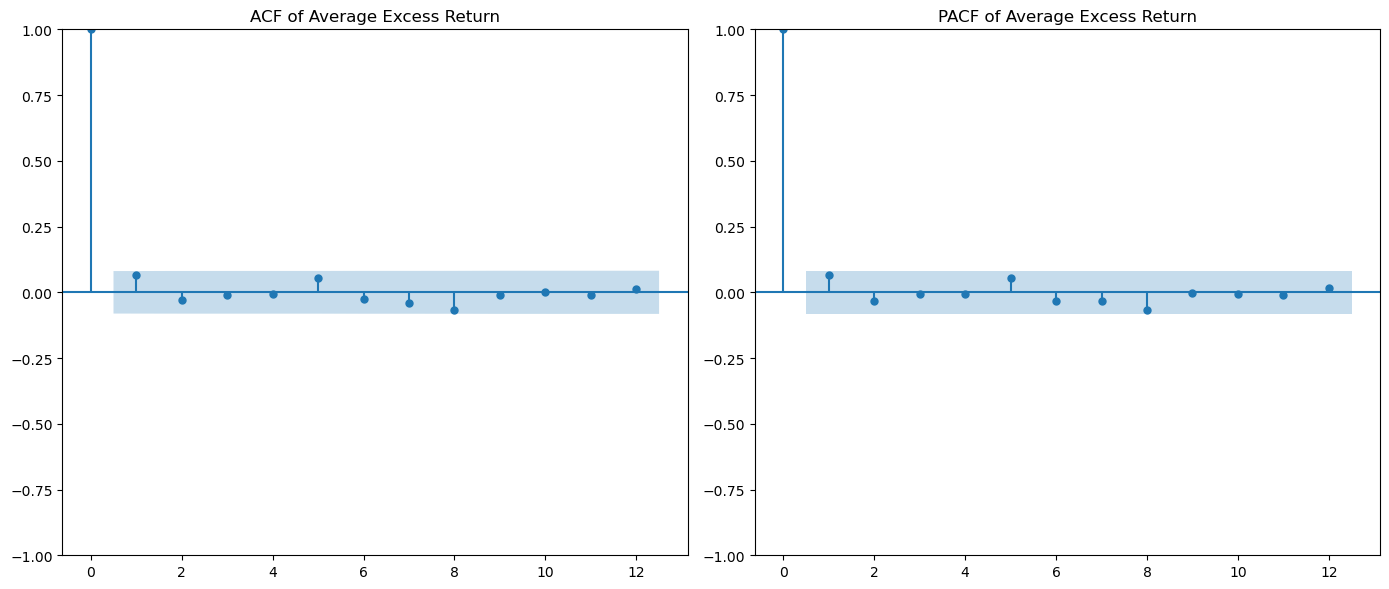

In [7]:
# 2) check for autocorrelation between r and the lagged variables using pacf
# Aggregate 'r' by month (average excess return)
r_mean = train.groupby(train.index)['r'].mean()
# Plot ACF and PACF
plt.figure(figsize=(14, 6))
# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(r_mean, lags=12, ax=plt.gca())
plt.title('ACF of Average Excess Return')
# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(r_mean, lags=12, ax=plt.gca(), method='ywm')
plt.title('PACF of Average Excess Return')
plt.tight_layout()
plt.show()

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_83917/2672906268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['me_quantile'] = pd.qcut(train['me_lg1'], 10, labels=False) + 1  # Labels 1 to 10


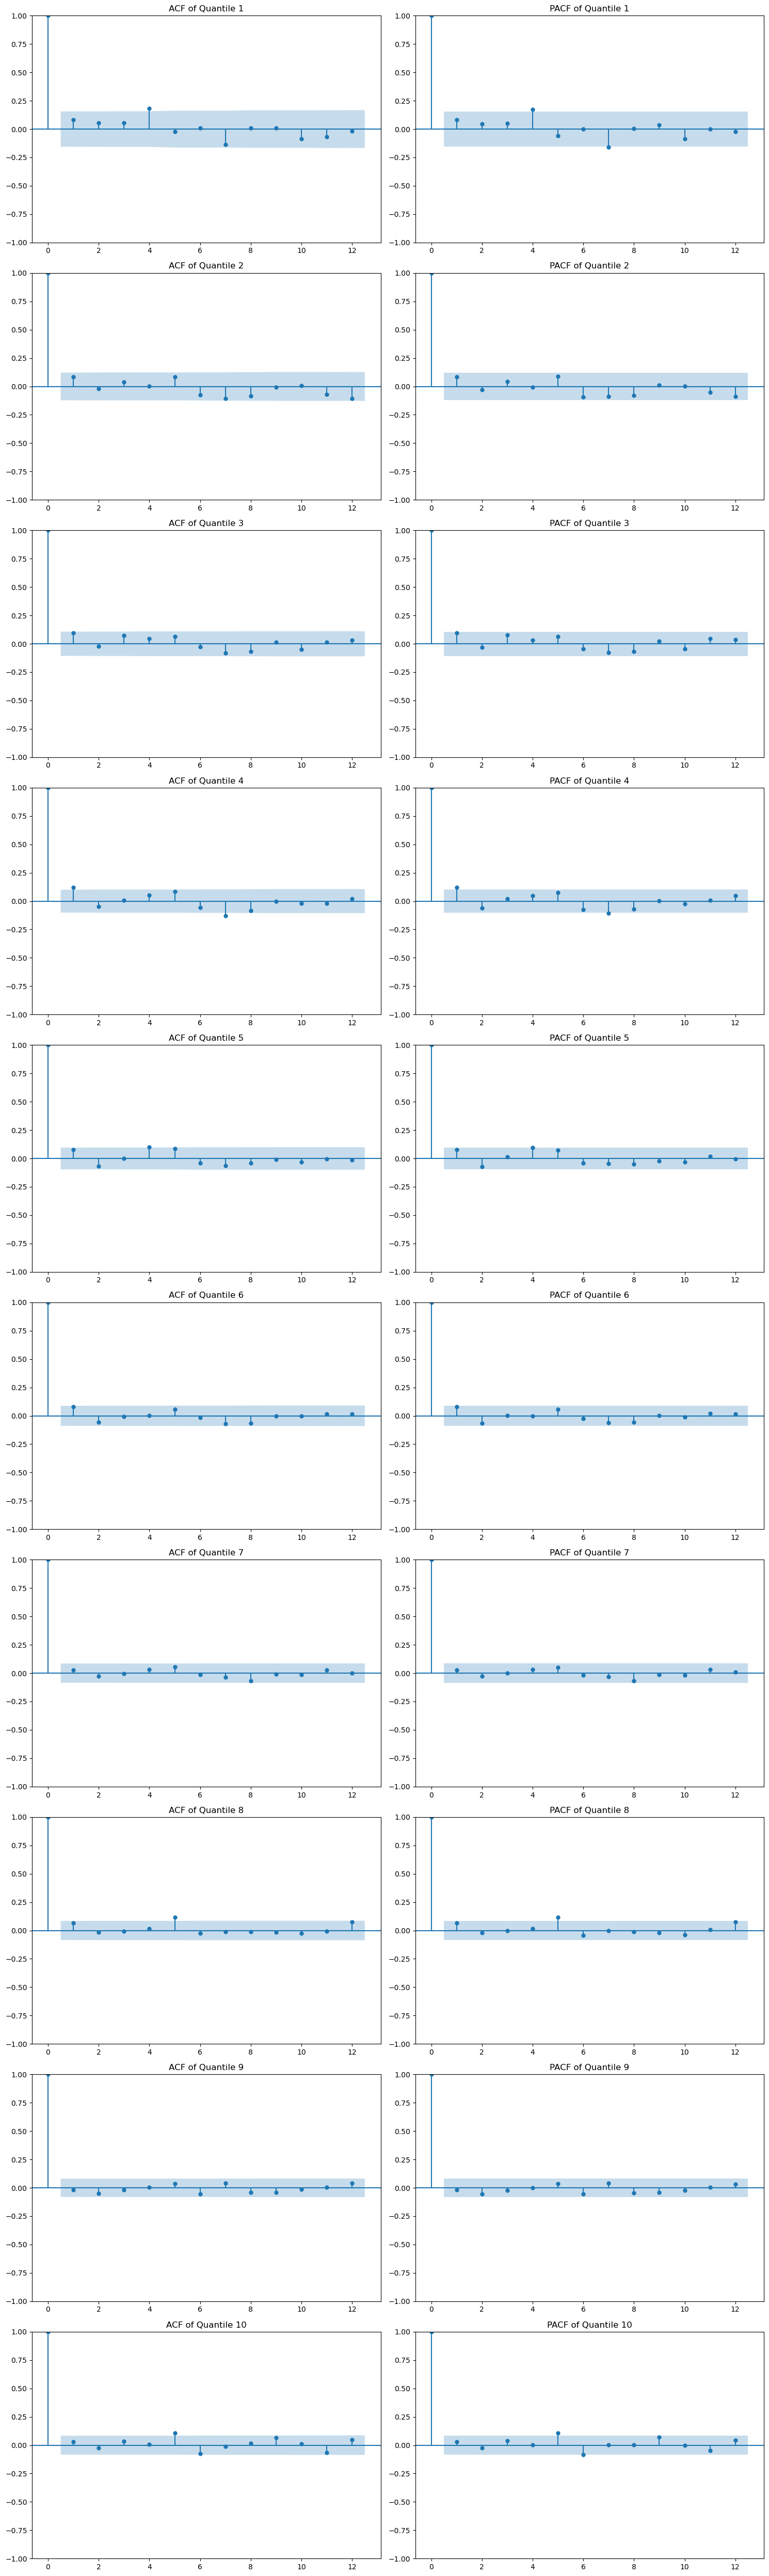

In [12]:
# 1. Splitting the Data into 10 Quantiles
train['me_quantile'] = pd.qcut(train['me_lg1'], 10, labels=False) + 1  # Labels 1 to 10

# Verify the quantile distribution
# quantile_counts = train['me_quantile'].value_counts().sort_index()
# print("Number of observations in each quantile:")
# print(quantile_counts)

# 2. Aggregating Excess Returns by Quantile and Month
aggregated_returns = train.groupby(['me_quantile', train.index])['r'].mean().reset_index()
pivot_returns = aggregated_returns.pivot(index='eom', columns='me_quantile', values='r')
pivot_returns = pivot_returns.sort_index()

# 3. Plotting ACF and PACF for Each Quantile
num_quantiles = 10
num_lags = 12

fig, axes = plt.subplots(nrows=num_quantiles, ncols=2, figsize=(15, 5 * num_quantiles))

for quantile in range(1, num_quantiles + 1):
    ts = pivot_returns[quantile].dropna()
    
    # Plot ACF
    plot_acf(ts, lags=num_lags, ax=axes[quantile-1, 0], alpha=0.05)
    axes[quantile-1, 0].set_title(f'ACF of Quantile {quantile}')
    
    # Plot PACF
    plot_pacf(ts, lags=num_lags, ax=axes[quantile-1, 1], method='ywm', alpha=0.05)
    axes[quantile-1, 1].set_title(f'PACF of Quantile {quantile}')

plt.tight_layout()
plt.show()

In [14]:

# Step 4: Extract average 'r' for quantile10 and quantile1
quantile10 = aggregated_returns[aggregated_returns['me_quantile'] == 10].set_index('eom')['r']
quantile1 = aggregated_returns[aggregated_returns['me_quantile'] == 1].set_index('eom')['r']

# Step 5: Calculate the difference series (Quantile 10 - Quantile 1)
difference_series = quantile10.subtract(quantile1, fill_value=0)

# Step 6: Apply first-order differencing
difference_series_diff = difference_series.diff().dropna()

# Step 7: Prepare 'difference_series_diff' for merging
difference_series_diff = difference_series_diff.rename('difference_series_diff')
difference_series_diff = difference_series_diff.reset_index()

# Step 8: Merge 'difference_series_diff' into 'train' dataframe on 'eom'
train = pd.merge(train, difference_series_diff, on='eom', how='left')


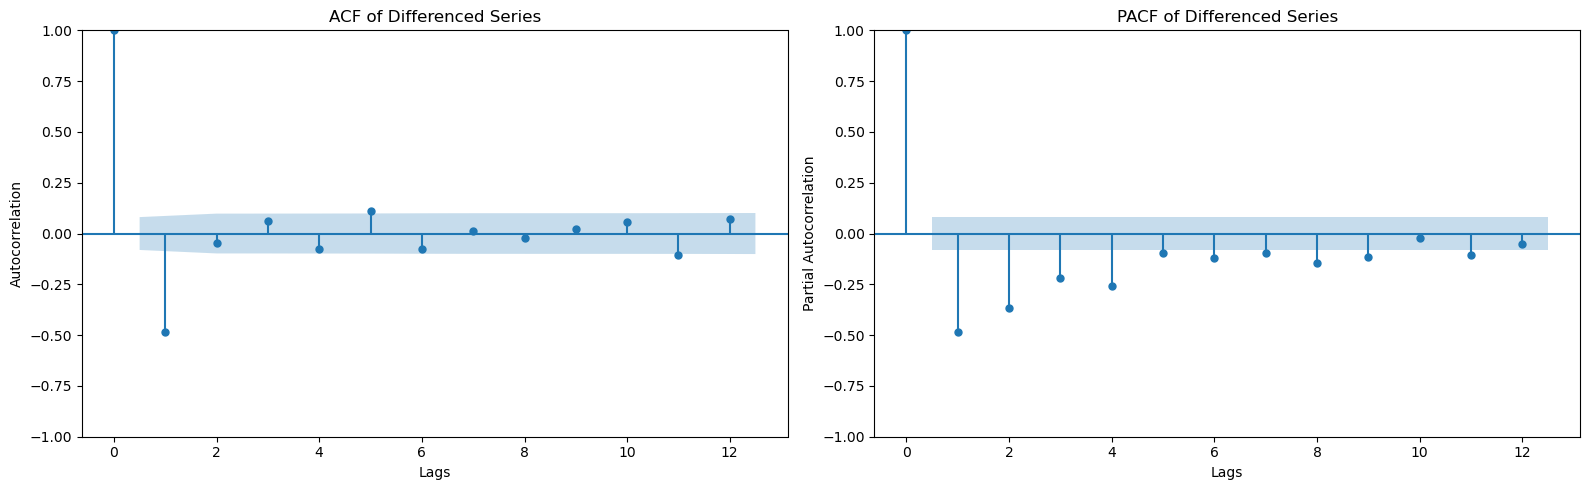

In [16]:
# ACF and PACF for differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF Plot
plot_acf(difference_series_diff['difference_series_diff'], lags=num_lags, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF of Differenced Series')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# PACF Plot
plot_pacf(difference_series_diff['difference_series_diff'], lags=num_lags, ax=axes[1], method='ywm', alpha=0.05)
axes[1].set_title('PACF of Differenced Series')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


In [20]:
# # implementing rules :

# Step 9: Drop rows with NaN values in 'difference_series_diff'
train_clean = train.dropna(subset=['difference_series_diff'])
difference_series_diff
# Step 10: Define explanatory variables for Prediction Rule 1
explanatory_vars_rule1 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', "me_lg1"]
aggregated_train = train_clean.groupby('eom')[explanatory_vars_rule1].mean().reset_index()

# Merge with 'difference_series_diff'
aggregated_train = pd.merge(aggregated_train, difference_series_diff, on='eom')
aggregated_train
# Define 
# Step 11: Extract the relevant data for Prediction Rule 1
X_rule1 = aggregated_train[explanatory_vars_rule1]
y_rule1 = aggregated_train['difference_series_diff']

# Step 12: Add a constant term for the intercept
X_rule1_const = sm.add_constant(X_rule1)

# Step 13: Fit the OLS model
model_rule1 = sm.OLS(y_rule1, X_rule1_const).fit()

# Step 14: Predict the target variable using the fitted OLS model
y_pred_rule1 = model_rule1.predict(X_rule1_const)

# Step 15: Calculate Mean Squared Error (MSE)
mse_rule1 = mean_squared_error(y_rule1, y_pred_rule1)

# Step 16: Extract Adjusted R-squared from the model
adjusted_r2_rule1 = model_rule1.rsquared_adj

# Step 17: Print the OLS Summary, MSE, and Adjusted R-squared
print("=== Prediction Rule 1: OLS Summary ===")
print(model_rule1.summary())
print(f"\nMean Squared Error (MSE): {mse_rule1:.4f}")
print(f"Adjusted R-squared: {adjusted_r2_rule1:.4f}")

=== Prediction Rule 1: OLS Summary ===
                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.218
Model:                                OLS   Adj. R-squared:                  0.212
Method:                     Least Squares   F-statistic:                     32.46
Date:                    Thu, 21 Nov 2024   Prob (F-statistic):           3.23e-29
Time:                            23:07:06   Log-Likelihood:                 932.67
No. Observations:                     587   AIC:                            -1853.
Df Residuals:                         581   BIC:                            -1827.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [14]:
# Define explanatory variables for Prediction Rule 2
explanatory_vars_rule2 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg5', 'me_lg1']

# Step 12: Aggregate explanatory variables by 'eom'
aggregated_train_2 = train_clean.groupby('eom')[explanatory_vars_rule2].mean().reset_index()

# Merge with 'difference_series_diff'
aggregated_train_2 = pd.merge(aggregated_train_2, difference_series_diff, on='eom')
aggregated_train_2

# Extract the relevant data from 'train_clean'
X_rule2 = aggregated_train_2[explanatory_vars_rule2]
y_rule2 = aggregated_train_2['difference_series_diff']

# Add a constant term for the intercept
X_rule2_const = sm.add_constant(X_rule2)

# Fit the OLS model
model_rule2 = sm.OLS(y_rule2, X_rule2_const).fit()

# Predict the target variable using the fitted OLS model
y_pred_rule2 = model_rule2.predict(X_rule2_const)

# Calculate Mean Squared Error (MSE)
mse_rule2 = mean_squared_error(y_rule2, y_pred_rule2)

# Extract R-squared and Adjusted R-squared from the model
# r2_rule2 = model_rule2.rsquared
adjusted_r2_rule2 = model_rule2.rsquared_adj

# Print the OLS Summary, MSE, R-squared, and Adjusted R-squared
print("\n=== Prediction Rule 2: OLS Summary ===")
print(model_rule2.summary())
print(f"\nMean Squared Error (MSE): {mse_rule2:.4f}")
print(f"Adjusted R-squared: {adjusted_r2_rule2:.4f}")



=== Prediction Rule 2: OLS Summary ===
                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.226
Model:                                OLS   Adj. R-squared:                  0.218
Method:                     Least Squares   F-statistic:                     28.26
Date:                    Sun, 10 Nov 2024   Prob (F-statistic):           1.12e-29
Time:                            19:09:43   Log-Likelihood:                 935.63
No. Observations:                     587   AIC:                            -1857.
Df Residuals:                         580   BIC:                            -1827.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [22]:
# # # Assuming 'train' dataframe is already loaded

# # # Step 10: Define the lags to be used
# # lags = [1, 2, 3, 4, 8]

# # # Step 11: Create lagged features
# # for lag in lags:
# #     train[f'difference_lag_{lag}'] = train['difference_series_diff'].shift(lag)

# # # Step 12: Drop rows with NaN values resulting from lagging
# # ridge_data = train.dropna(subset=[f'difference_lag_{lag}' for lag in lags])

# # # Step 13: Define explanatory variables for Prediction Rule 3
# # explanatory_vars_rule3 = [f'difference_lag_{lag}' for lag in lags]

# # # Step 14: Extract the relevant data
# # X_rule3 = ridge_data[explanatory_vars_rule3]
# # y_rule3 = ridge_data['difference_series_diff']

# # # list of alphas to check: 100 values from 0 to 5 with
# # r_alphas = np.logspace(0, 2, 1000)
# # # initiate the cross validation over alphas
# # ridge_model = RidgeCV(alphas=r_alphas, scoring='r2')
# # # fit the model with the best alpha
# # ridge_model = ridge_model.fit(X_rule3, y_rule3)
# # print(f'Optimal alpha: {ridge_model.alpha_}')

# # print(ridge_model.coef_)

# # y_pred = ridge_model.predict(X_rule3)
# # mse = mean_squared_error(y_rule3, y_pred)
# # print(mse)
# # r2 = r2_score(y_rule3, y_pred)
# # print(r2)
# # --- Step 1: Define Lags and Create Lagged Features ---
# lags = [1, 2, 3, 4, 8]
# for lag in lags:
#     train[f'difference_lag_{lag}'] = train['difference_series_diff'].shift(lag)

# # --- Step 2: Drop Rows with NaN Values ---
# ridge_data = train.dropna(subset=[f'difference_lag_{lag}' for lag in lags])

# # --- Step 3: Define Features and Target ---
# explanatory_vars_rule3 = [f'difference_lag_{lag}' for lag in lags]
# X = ridge_data[explanatory_vars_rule3]
# y = ridge_data['difference_series_diff']

# # --- Step 4: Train-Test Split (Maintain Temporal Order) ---
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, shuffle=False
# )

# # --- Step 5: Feature Scaling ---
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

# # --- Step 6: Define and Fit RidgeCV Model ---
# r_alphas = np.logspace(0, 5, 100)  # 100 alphas from 1 to 100,000
# tscv = TimeSeriesSplit(n_splits=5)
# ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=tscv)
# ridge_model.fit(X_train_scaled, y_train)

# # --- Step 7: Print Optimal Alpha and Coefficients ---
# print(f'Optimal alpha: {ridge_model.alpha_}')
# coefficients = pd.Series(ridge_model.coef_, index=explanatory_vars_rule3)
# print('\nCoefficients:')
# print(coefficients)

# # --- Step 8: Predictions and Evaluation on Training Set ---
# y_pred_train = ridge_model.predict(X_train_scaled)
# mse_train = mean_squared_error(y_train, y_pred_train)
# r2_train = r2_score(y_train, y_pred_train)
# print(f'\nTraining MSE: {mse_train:.4f}')
# print(f'Training R²: {r2_train:.4f}')

# # --- Step 9: Predictions and Evaluation on Validation Set ---
# y_pred_val = ridge_model.predict(X_val_scaled)
# mse_val = mean_squared_error(y_val, y_pred_val)
# r2_val = r2_score(y_val, y_pred_val)
# print(f'Validation MSE: {mse_val:.4f}')
# print(f'Validation R²: {r2_val:.4f}')


In [50]:
# ----- Prediction Rule 3: OLS Regression on Train Data using normal OLS isntead of Ridge -----
import statsmodels.formula.api as smf
# --- Step 1: Define Lags and Create Lagged Features ---
lags = [1, 2, 3, 4, 8]
###########################
explanatory_vars_rule3 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg8', 'me_lg1']

# Step 12: Aggregate explanatory variables by 'eom'
aggregated_train_3 = train_clean.groupby('eom')[explanatory_vars_rule3].mean().reset_index()
# Merge with 'difference_series_diff'
aggregated_train_3 = pd.merge(aggregated_train_3, difference_series_diff, on='eom')
# aggregated_train_3


# --- Step 6: Define and Fit OLS Model using smf.ols ---
formula = 'difference_series_diff ~ ' + ' + '.join(explanatory_vars_rule3)
ols_model = smf.ols(formula=formula, data=aggregated_train_3).fit()

# --- Step 7: Print Coefficients ---
print('\nCoefficients:')
print(ols_model.summary())


Coefficients:
                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.224
Model:                                OLS   Adj. R-squared:                  0.216
Method:                     Least Squares   F-statistic:                     27.98
Date:                    Sun, 10 Nov 2024   Prob (F-statistic):           2.11e-29
Time:                            19:27:08   Log-Likelihood:                 934.98
No. Observations:                     587   AIC:                            -1856.
Df Residuals:                         580   BIC:                            -1825.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [80]:
# # ----- Prediction Rule 3: Ridge Regression on Train Data -----

# from sklearn.linear_model import RidgeCV
# from sklearn.preprocessing import StandardScaler

# # --- Step 1: Define Lags and Create Lagged Features ---
# lags = [1, 2, 3, 4, 8]
# ###########################
# explanatory_vars_rule3 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg8', 'me_lg1']

# # Step 12: Aggregate explanatory variables by 'eom'
# aggregated_train_3 = train_clean.groupby('eom')[explanatory_vars_rule3].mean().reset_index()
# # Merge with 'difference_series_diff'
# aggregated_train_3 = pd.merge(aggregated_train_3, difference_series_diff, on='eom')

# # --- Step: Define Features and Target ---
# X_train = aggregated_train_3[explanatory_vars_rule3]
# y_train = aggregated_train_3['difference_series_diff']

# # --- Step: Feature Scaling ---
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # --- Step: Define and Fit Ridge Regression Model ---
# alphas = np.logspace(-3, 3, 100)
# ridge_cv = RidgeCV(alphas=alphas, cv=5)
# ridge_cv.fit(X_train_scaled, y_train)

# # --- Step: Print Coefficients ---
# print(f'Optimal alpha: {ridge_cv.alpha_}')
# coefficients = pd.Series(ridge_cv.coef_, index=explanatory_vars_rule3)
# print('\nCoefficients:')
# print(coefficients)


Optimal alpha: 23.10129700083158

Coefficients:
r_lg1    -0.001078
r_lg2    -0.000063
r_lg3     0.000060
r_lg4    -0.000074
r_lg8    -0.000132
me_lg1   -0.000032
dtype: float64

Training MSE: 0.0031
Training R²: 0.0180


In [54]:
# ----- Prediction Rule 1: OLS Regression on Test Data -----

test = test.sort_values(by='eom')

# Assign 10 quantiles based on 'me_lg1'
test['me_quantile'] = pd.qcut(test['me_lg1'], 10, labels=False) + 1

# Aggregate average excess returns for each quantile and month
aggregated_returns_test = test.groupby(['me_quantile', 'eom'])['r'].mean().reset_index()

# Extract average 'r' for quantile10 and quantile1
quantile10_test = aggregated_returns_test[aggregated_returns_test['me_quantile'] == 10].set_index('eom')['r']
quantile1_test = aggregated_returns_test[aggregated_returns_test['me_quantile'] == 1].set_index('eom')['r']

# Calculate the difference series (Quantile 10 - Quantile 1)
difference_series_test = quantile10_test.subtract(quantile1_test, fill_value=0)

# Apply first-order differencing
difference_series_diff_test = difference_series_test.diff().dropna()

# Prepare 'difference_series_diff' for merging
difference_series_diff_test_df = difference_series_diff_test.reset_index()
difference_series_diff_test_df.rename(columns={'r': 'difference_series_diff'}, inplace=True)

# Merge 'difference_series_diff' into test dataframe on 'eom'
test_clean = pd.merge(test, difference_series_diff_test_df, on='eom', how='left')

# Drop rows with NaN values in 'difference_series_diff'
test_clean = test_clean.dropna(subset=['difference_series_diff'])
test_clean
# Define explanatory variables for Prediction Rule 1
explanatory_vars_rule1 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4']

# Step 12: Aggregate explanatory variables by 'eom'
aggregated_test_1 = test_clean.groupby('eom')[explanatory_vars_rule1].mean().reset_index()
aggregated_test_1 = pd.merge(aggregated_test_1, difference_series_diff_test_df, on='eom')

# Extract the relevant data for Prediction Rule 1
X_test_rule1 = aggregated_test_1[explanatory_vars_rule1]
y_test_rule1 = aggregated_test_1['difference_series_diff']

# Add a constant term for the intercept
X_test_rule1_const = sm.add_constant(X_test_rule1)

# Make predictions
y_pred_rule1_test = model_rule1.predict(X_test_rule1_const)

# Calculate MSE
mse_rule1_test = mean_squared_error(y_test_rule1, y_pred_rule1_test)

# Calculate R-squared
r2_rule1_test = r2_score(y_test_rule1, y_pred_rule1_test)

# Calculate Adjusted R-squared
n_test = len(y_test_rule1)
p_rule1 = len(explanatory_vars_rule1) + 1
adjusted_r2_rule1_test = 1 - (1 - r2_rule1_test) * (n_test - 1) / (n_test - p_rule1)

# Print performance metrics
print("\n=== Prediction Rule 1: OLS Test Performance ===")
print(f"Mean Squared Error (MSE): {mse_rule1_test:.4f}")
print(f"R-squared (R²): {r2_rule1_test:.4f}")
print(f"Adjusted R-squared: {adjusted_r2_rule1_test:.4f}")


=== Prediction Rule 1: OLS Test Performance ===
Mean Squared Error (MSE): 0.0029
R-squared (R²): 0.0482
Adjusted R-squared: 0.0347


In [56]:
# ----- Prediction Rule 2: OLS Regression on Test Data -----

# Define explanatory variables for Prediction Rule 2
explanatory_vars_rule2 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg5', 'me_lg1']

# Step 12: Aggregate explanatory variables by 'eom'
aggregated_test_2 = test_clean.groupby('eom')[explanatory_vars_rule2].mean().reset_index()
aggregated_test_2 = pd.merge(aggregated_test_2, difference_series_diff_test_df, on='eom')

# Extract the relevant data for Prediction Rule 1
X_test_rule2 = aggregated_test_2[explanatory_vars_rule2]
y_test_rule2 = aggregated_test_2['difference_series_diff']

# Add a constant term for the intercept
X_test_rule2_const = sm.add_constant(X_test_rule2)

# Make predictions using the trained OLS model
y_pred_rule2_test = model_rule2.predict(X_test_rule2_const)

# Calculate Mean Squared Error (MSE)
mse_rule2_test = mean_squared_error(y_test_rule2, y_pred_rule2_test)

# Calculate R-squared (R²)
r2_rule2_test = r2_score(y_test_rule2, y_pred_rule2_test)

# Calculate Adjusted R-squared
p_rule2 = len(explanatory_vars_rule2) + 1  # +1 for intercept
adjusted_r2_rule2_test = 1 - (1 - r2_rule2_test) * (n_test - 1) / (n_test - p_rule2)

# Print performance metrics
print("\n=== Prediction Rule 2: OLS Test Performance ===")
print(f"Mean Squared Error (MSE): {mse_rule2_test:.4f}")
print(f"R-squared (R²): {r2_rule2_test:.4f}")
print(f"Adjusted R-squared: {adjusted_r2_rule2_test:.4f}")



=== Prediction Rule 2: OLS Test Performance ===
Mean Squared Error (MSE): 0.0030
R-squared (R²): 0.0253
Adjusted R-squared: 0.0044


In [58]:
# # # ----- Prediction Rule 3: Ridge Regression on Test Data ----- note that no data standardized as all variables on same scale
# # # Assuming 'test' dataframe is already loaded and has 'eom' and 'difference_series_diff' columns

# # # Step 19: Aggregate explanatory variables by 'eom' and compute their mean
# # for lag in lags:
# #     difference_series_diff_test_df[f'difference_lag_{lag}'] = difference_series_diff_test_df['difference_series_diff'].shift(lag)

# # aggregated_test_3 = difference_series_diff_test_df


# # # Step 21: Drop rows with NaN values resulting from lagging
# # ridge_test_data = aggregated_test_3.dropna()

# # # Step 22: Extract the relevant data for Prediction Rule 3
# # X_test_rule3 = ridge_test_data[explanatory_vars_rule3]
# # y_test_rule3 = ridge_test_data['difference_series_diff']

# # # Add a constant term for the intercept
# # X_test_rule1_const = sm.add_constant(X_test_rule1)

# # # Make predictions
# # y_pred_rule1_test = model_rule1.predict(X_test_rule1_const)

# # # Calculate MSE
# # mse_rule1_test = mean_squared_error(y_test_rule1, y_pred_rule1_test)

# # # Calculate R-squared
# # r2_rule1_test = r2_score(y_test_rule1, y_pred_rule1_test)

# # # Calculate Adjusted R-squared
# # n_test = len(y_test_rule1)
# # p_rule1 = len(explanatory_vars_rule1) + 1
# # adjusted_r2_rule1_test = 1 - (1 - r2_rule1_test) * (n_test - 1) / (n_test - p_rule1)

# # # Print performance metrics
# # print("\n=== Prediction Rule 1: OLS Test Performance ===")
# # print(f"Mean Squared Error (MSE): {mse_rule1_test:.4f}")
# # print(f"R-squared (R²): {r2_rule1_test:.4f}")
# # print(f"Adjusted R-squared: {adjusted_r2_rule1_test:.4f}")


# # --- Step 1: Define Lags and Create Lagged Features ---
# lags = [1, 2, 3, 4, 8]
# # difference_series_diff = difference_series_diff.set_index("eom")
# test.index = pd.to_datetime(test.index)
# test = pd.merge(test, difference_series_diff, left_index=True,right_index=True)
# for lag in lags:
#     test[f'difference_lag_{lag}'] = test['difference_series_diff'].shift(lag)

# # --- Step 2: Drop Rows with NaN Values ---
# ridge_test_data = test.dropna(subset=[f'difference_lag_{lag}' for lag in lags])

# # --- Step 3: Define Features and Target ---
# explanatory_vars_rule3 = [f'difference_lag_{lag}' for lag in lags]
# X_test_rule3 = ridge_test_data[explanatory_vars_rule3]
# y_test_rule3 = ridge_test_data['difference_series_diff']

# # --- Step 4: Make Predictions ---
# y_pred_test = ridge_model.predict(X_test_rule3)

# # --- Step 5: Calculate and Print Performance Metrics ---
# mse_test = mean_squared_error(y_test_rule3, y_pred_test)
# r2_test = r2_score(y_test_rule3, y_pred_test)

# print("\n=== Ridge Regression Test Performance ===")
# print(f"Mean Squared Error (MSE): {mse_test:.4f}")
# print(f"R-squared (R²): {r2_test:.4f}")

In [82]:
# ----- Prediction Rule 3: OLS Regression on Test Data -----

# Define explanatory variables for Prediction Rule 3
explanatory_vars_rule3 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg8', 'me_lg1']

# Step 12: Aggregate explanatory variables by 'eom'
aggregated_test_3 = test_clean.groupby('eom')[explanatory_vars_rule3].mean().reset_index()
aggregated_test_3 = pd.merge(aggregated_test_3, difference_series_diff_test_df, on='eom')

# Extract the relevant data for Prediction Rule 3
X_test_rule3 = aggregated_test_3[explanatory_vars_rule3]
y_test_rule3 = aggregated_test_3['difference_series_diff']

# --- Step: Define and Fit OLS Model on Test Data using smf.ols ---
formula = 'difference_series_diff ~ ' + ' + '.join(explanatory_vars_rule3)
ols_model_test = smf.ols(formula=formula, data=aggregated_test_3).fit()

# --- Step: Print Regression Results ---
print(ols_model_test.summary())


                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.102
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     5.281
Date:                    Sun, 10 Nov 2024   Prob (F-statistic):           3.55e-05
Time:                            19:38:15   Log-Likelihood:                 437.65
No. Observations:                     287   AIC:                            -861.3
Df Residuals:                         280   BIC:                            -835.7
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [64]:
# evaluating economic significance:
def pf_sort(data, model=None, beta=None, intercept=0, explanatory_vars=[], n_pfs=10, annualize=True, save_path=None, title=""):
    if model is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = model.predict(X)
    elif beta is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = np.dot(X, beta) + intercept
    else:
        raise ValueError("Either model or beta must be provided.")
    
    # Assign to portfolios based on prediction percentiles
    data['pred_percentile'] = data['pred'].rank(pct=True)
    data['pf'] = np.ceil(data['pred_percentile'] * n_pfs).astype(int)
    data['pf'] = data['pf'].clip(upper=n_pfs)
    
    # Compute equal-weighted return of each portfolio in month t
    pfs = data.groupby(['pf', 'eom'])['r'].mean().reset_index(name='pf_ret')
    
    # Compute average return of each portfolio
    stock_summary = pfs.groupby('pf')['pf_ret'].mean().reset_index()
    if annualize:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret'] * 12
    else:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret']
    
    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')
    for index, row in stock_summary.iterrows():
        plt.text(row.pf - 1, row.pf_ret_annualized + 0.001, f"{row.pf_ret_annualized:.2f}", ha='center')
    plt.xlabel('Portfolios sorted by predicted return (1=low)')
    plt.ylabel('Average Return Annualized')
    plt.title(title if title else 'Portfolio Sort Based on Predicted Returns')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()
    
    return stock_summary

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


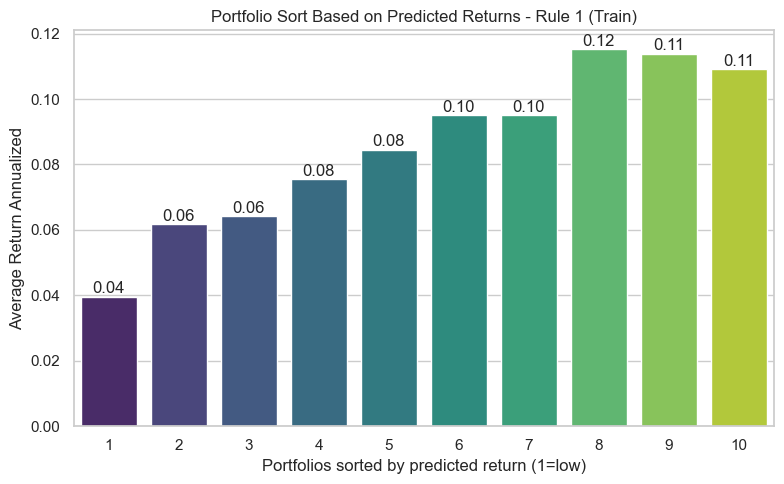


=== Prediction Rule 1: Portfolio Sort - Training Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003300           0.039603
1   2  0.005143           0.061711
2   3  0.005347           0.064159
3   4  0.006288           0.075451
4   5  0.007045           0.084539
5   6  0.007917           0.095006
6   7  0.007933           0.095195
7   8  0.009602           0.115226
8   9  0.009493           0.113911
9  10  0.009090           0.109077


In [66]:
# ----- Prediction Rule 1: Portfolio Sort on Training Data -----

# Define explanatory variables for Prediction Rule 1
explanatory_vars_rule1 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4']

# Apply portfolio sort on training data
train_summary_rule1 = pf_sort(
    data=train_clean,
    model=model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 1 (Train)"
)

# Print summary
print("\n=== Prediction Rule 1: Portfolio Sort - Training Data ===")
print(train_summary_rule1)

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


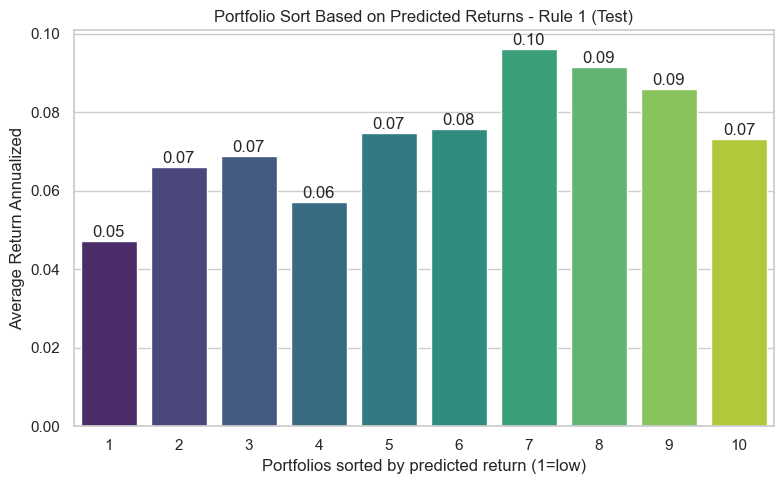


=== Prediction Rule 1: Portfolio Sort - Test Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003936           0.047227
1   2  0.005500           0.066004
2   3  0.005736           0.068831
3   4  0.004764           0.057172
4   5  0.006227           0.074719
5   6  0.006317           0.075802
6   7  0.008000           0.096002
7   8  0.007616           0.091398
8   9  0.007162           0.085949
9  10  0.006099           0.073191


In [68]:
# ----- Prediction Rule 1: Portfolio Sort on Test Data -----
# Define explanatory variables for Prediction Rule 1
explanatory_vars_rule1 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4']

# Apply portfolio sort on test data
test_summary_rule1 = pf_sort(
    data=test_clean,
    model=model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 1 (Test)"
)

# Print summary
print("\n=== Prediction Rule 1: Portfolio Sort - Test Data ===")
print(test_summary_rule1)

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


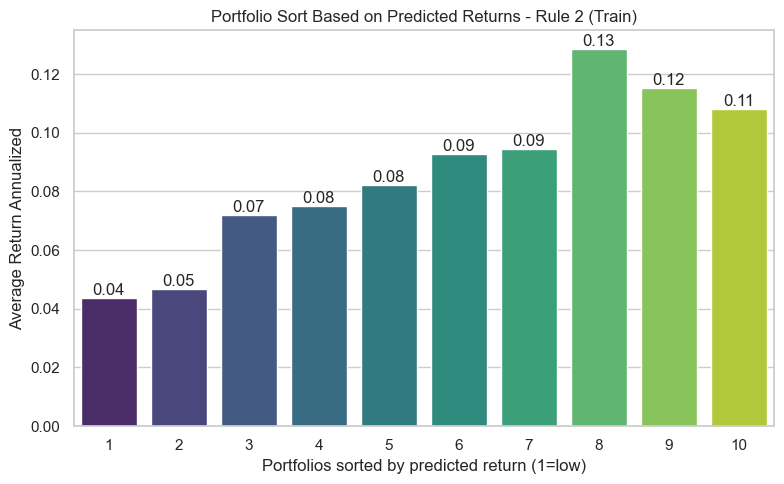

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')



=== Prediction Rule 2: Portfolio Sort - Training Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003650           0.043799
1   2  0.003889           0.046669
2   3  0.005999           0.071992
3   4  0.006256           0.075068
4   5  0.006845           0.082136
5   6  0.007731           0.092772
6   7  0.007884           0.094611
7   8  0.010707           0.128479
8   9  0.009595           0.115135
9  10  0.008998           0.107972


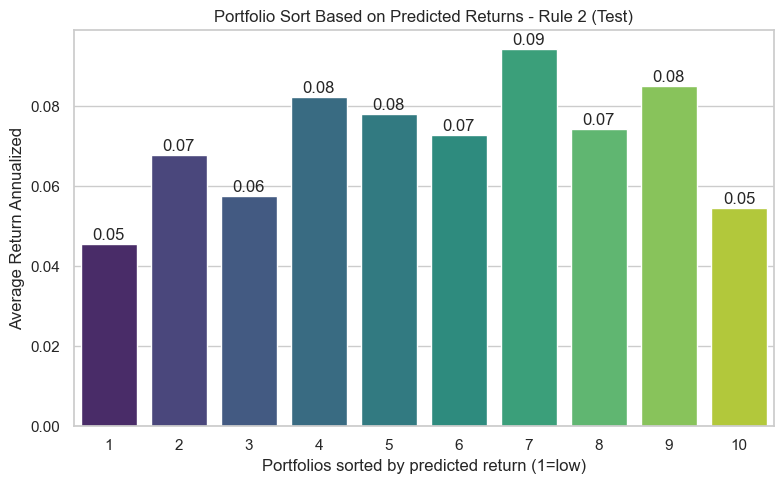


=== Prediction Rule 2: Portfolio Sort - Test Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003786           0.045437
1   2  0.005657           0.067884
2   3  0.004804           0.057653
3   4  0.006858           0.082296
4   5  0.006502           0.078023
5   6  0.006072           0.072859
6   7  0.007852           0.094229
7   8  0.006184           0.074209
8   9  0.007083           0.084996
9  10  0.004545           0.054536


In [74]:
# ----- Prediction Rule 2: Portfolio Sort on Training Data -----

# Define explanatory variables for Prediction Rule 2
explanatory_vars_rule2 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg5', 'me_lg1']

# Apply portfolio sort on training data
train_summary_rule2 = pf_sort(
    data=train_clean,
    model=model_rule2,
    explanatory_vars=explanatory_vars_rule2,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 2 (Train)"
)

# Print summary
print("\n=== Prediction Rule 2: Portfolio Sort - Training Data ===")
print(train_summary_rule2)

# ----- Prediction Rule 2: Portfolio Sort on Test Data -----

test_summary_rule2 = pf_sort(
    data=test_clean,
    model=model_rule2,
    explanatory_vars=explanatory_vars_rule2,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 2 (Test)"
)

# Print summary
print("\n=== Prediction Rule 2: Portfolio Sort - Test Data ===")
print(test_summary_rule2)

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


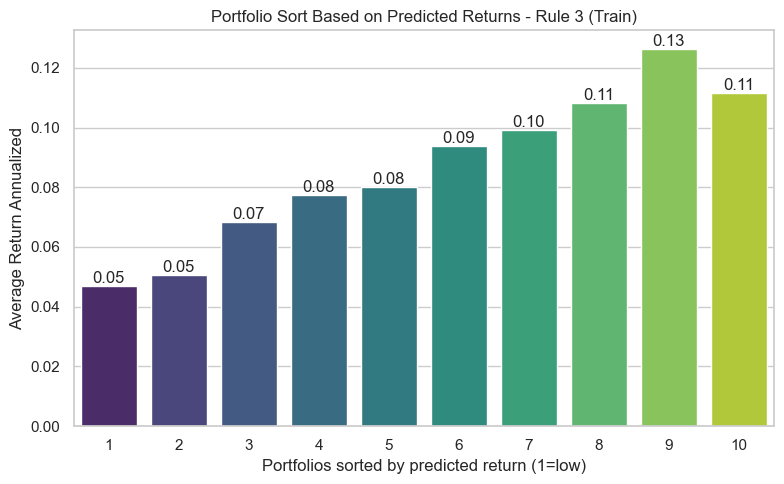


=== Prediction Rule 3: Portfolio Sort - Training Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003899           0.046784
1   2  0.004219           0.050630
2   3  0.005703           0.068431
3   4  0.006459           0.077503
4   5  0.006682           0.080178
5   6  0.007819           0.093833
6   7  0.008255           0.099066
7   8  0.009011           0.108133
8   9  0.010517           0.126210
9  10  0.009306           0.111673


/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2063182053.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


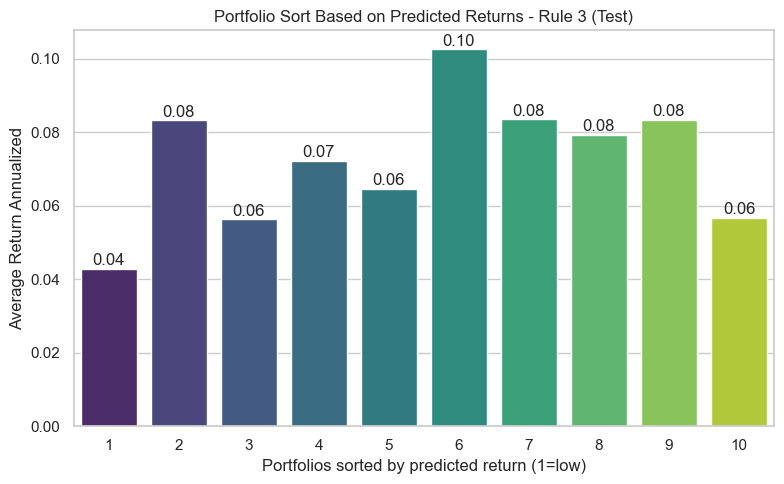


=== Prediction Rule 3: Portfolio Sort - Test Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003565           0.042782
1   2  0.006940           0.083279
2   3  0.004692           0.056302
3   4  0.006015           0.072176
4   5  0.005388           0.064660
5   6  0.008550           0.102595
6   7  0.006957           0.083484
7   8  0.006603           0.079241
8   9  0.006953           0.083438
9  10  0.004729           0.056746


In [76]:
# ----- Prediction Rule 3: Portfolio Sort on Training Data -----

# Define explanatory variables for Prediction Rule 3
explanatory_vars_rule3 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg8', 'me_lg1']

# Apply portfolio sort on training data
train_summary_rule3 = pf_sort(
    data=train_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 3 (Train)"
)

# Print summary
print("\n=== Prediction Rule 3: Portfolio Sort - Training Data ===")
print(train_summary_rule3)

# ----- Prediction Rule 3: Portfolio Sort on Test Data -----

# Apply portfolio sort on test data
test_summary_rule3 = pf_sort(
    data=test_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=10,
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 3 (Test)"
)

# Print summary
print("\n=== Prediction Rule 3: Portfolio Sort - Test Data ===")
print(test_summary_rule3)



=== OLS Regression Results: Prediction Rule 3 ===
                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.224
Model:                                OLS   Adj. R-squared:                  0.216
Method:                     Least Squares   F-statistic:                     27.98
Date:                    Sun, 10 Nov 2024   Prob (F-statistic):           2.11e-29
Time:                            19:47:32   Log-Likelihood:                 934.98
No. Observations:                     587   AIC:                            -1856.
Df Residuals:                         580   BIC:                            -1825.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2645405386.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


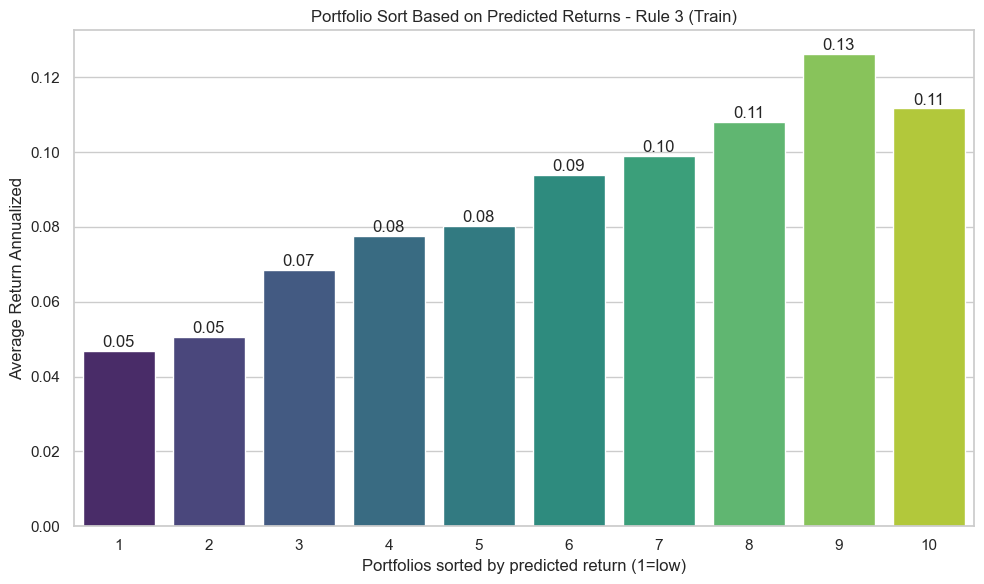


=== Prediction Rule 3: Portfolio Sort - Training Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003899           0.046784
1   2  0.004219           0.050630
2   3  0.005703           0.068431
3   4  0.006459           0.077503
4   5  0.006682           0.080178
5   6  0.007819           0.093833
6   7  0.008255           0.099066
7   8  0.009011           0.108133
8   9  0.010517           0.126210
9  10  0.009306           0.111673


/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/2645405386.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


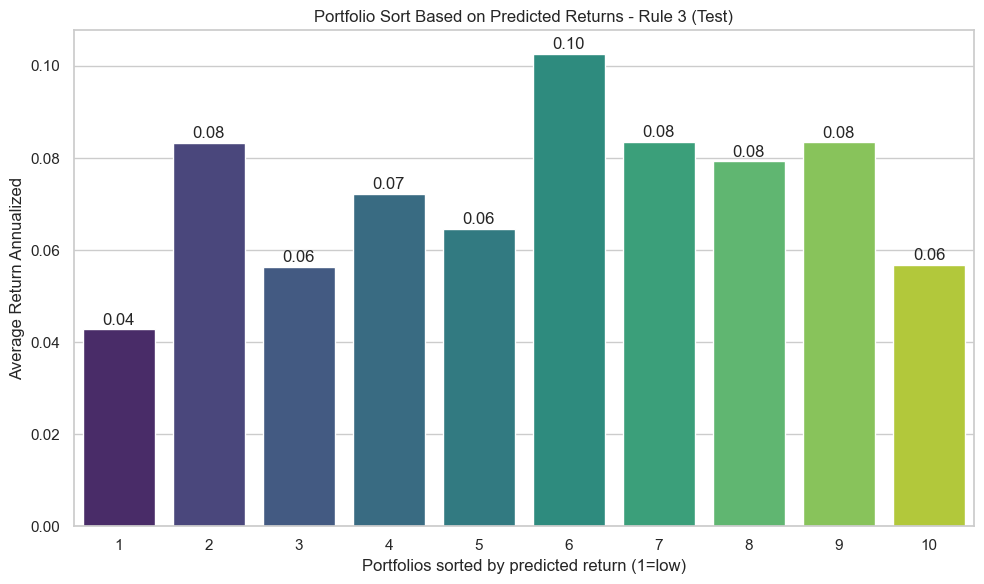


=== Prediction Rule 3: Portfolio Sort - Test Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003565           0.042782
1   2  0.006940           0.083279
2   3  0.004692           0.056302
3   4  0.006015           0.072176
4   5  0.005388           0.064660
5   6  0.008550           0.102595
6   7  0.006957           0.083484
7   8  0.006603           0.079241
8   9  0.006953           0.083438
9  10  0.004729           0.056746

=== Prediction Rule 3: Long-Short Portfolio - Training Data ===
Annualized Mean Return: 0.0678
Annualized Standard Deviation: 0.1682
Sharpe Ratio: 0.2842

=== Prediction Rule 3: Long-Short Portfolio - Test Data ===
Annualized Mean Return: 0.0095
Annualized Standard Deviation: 0.2035
Sharpe Ratio: -0.0516


In [95]:
# ----- Prediction Rule 3: OLS Regression on Train Data using normal OLS instead of Ridge -----
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 1: Define Lags and Create Lagged Features ---
lags = [1, 2, 3, 4, 8]
# (Assuming lagged features are already created in `train_clean`)

# --- Step 2: Define Explanatory Variables ---
explanatory_vars_rule3 = ['r_lg1', 'r_lg2', 'r_lg3', 'r_lg4', 'r_lg8', 'me_lg1']

# --- Step 3: Aggregate explanatory variables by 'eom' ---
aggregated_train_3 = train_clean.groupby('eom')[explanatory_vars_rule3].mean().reset_index()
# Merge with 'difference_series_diff'
aggregated_train_3 = pd.merge(aggregated_train_3, difference_series_diff, on='eom')

# --- Step 4: Define and Fit OLS Model using smf.ols ---
formula = 'difference_series_diff ~ ' + ' + '.join(explanatory_vars_rule3)
ols_model = smf.ols(formula=formula, data=aggregated_train_3).fit()

# --- Step 5: Print Regression Results ---
print('\n=== OLS Regression Results: Prediction Rule 3 ===')
print(ols_model.summary())

# ----- Portfolio Sort Function -----
# Evaluating economic significance:
def pf_sort(data, model=None, beta=None, intercept=0, explanatory_vars=[], n_pfs=10, annualize=True, save_path=None, title=""):
    """
    Sorts data into portfolios based on predicted returns and computes average returns.

    Parameters:
    - data (DataFrame): Input data containing returns and explanatory variables.
    - model: Trained regression model with a .predict() method.
    - beta (array-like): Coefficients for manual prediction.
    - intercept (float): Intercept for manual prediction.
    - explanatory_vars (list): List of explanatory variable names.
    - n_pfs (int): Number of portfolios to sort into.
    - annualize (bool): Whether to annualize the returns.
    - save_path (str): Path to save the plot.
    - title (str): Title for the plot.

    Returns:
    - stock_summary (DataFrame): Summary of portfolio returns.
    """
    if model is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = model.predict(X)
    elif beta is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = np.dot(X, beta) + intercept
    else:
        raise ValueError("Either model or beta must be provided.")
    
    # Assign to portfolios based on prediction percentiles
    data['pred_percentile'] = data['pred'].rank(pct=True)
    data['pf'] = np.ceil(data['pred_percentile'] * n_pfs).astype(int)
    data['pf'] = data['pf'].clip(upper=n_pfs)
    
    # Compute equal-weighted return of each portfolio in month t
    pfs = data.groupby(['pf', 'eom'])['r'].mean().reset_index(name='pf_ret')
    
    # Compute average return of each portfolio
    stock_summary = pfs.groupby('pf')['pf_ret'].mean().reset_index()
    if annualize:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret'] * 12
    else:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret']
    
    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')
    for index, row in stock_summary.iterrows():
        plt.text(row.pf - 1, row.pf_ret_annualized + 0.001, f"{row.pf_ret_annualized:.2f}", ha='center')
    plt.xlabel('Portfolios sorted by predicted return (1=low)')
    plt.ylabel('Average Return Annualized')
    plt.title(title if title else 'Portfolio Sort Based on Predicted Returns')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()
    
    return stock_summary

# ----- Long-Short Portfolio Function -----
def create_long_short_portfolio(data, model, explanatory_vars, n_pfs=10, n_long=1, n_short=1, risk_free_rate=0.02, annualize=True):
    """
    Creates a long-short portfolio by going long the top n_long portfolios and short the bottom n_short portfolios.

    Parameters:
    - data (DataFrame): Input data containing returns and explanatory variables.
    - model: Trained regression model with a .predict() method.
    - explanatory_vars (list): List of explanatory variable names.
    - n_pfs (int): Number of portfolios used in sorting.
    - n_long (int): Number of top portfolios to long.
    - n_short (int): Number of bottom portfolios to short.
    - risk_free_rate (float): Annual risk-free rate (default 2%).
    - annualize (bool): Whether to annualize the returns.

    Returns:
    - mean_return_annualized (float): Annualized mean return of the long-short portfolio.
    - std_return_annualized (float): Annualized standard deviation of the long-short portfolio.
    - sharpe_ratio (float): Sharpe Ratio of the long-short portfolio.
    """
    # Predict returns
    X = sm.add_constant(data[explanatory_vars])
    data = data.copy()
    data['pred'] = model.predict(X)
    
    # Assign to portfolios based on prediction percentiles
    data['pred_percentile'] = data['pred'].rank(pct=True)
    data['pf'] = np.ceil(data['pred_percentile'] * n_pfs).astype(int)
    data['pf'] = data['pf'].clip(upper=n_pfs)
    
    # Compute equal-weighted returns of portfolios over time
    pfs = data.groupby(['pf', 'eom'])['r'].mean().reset_index(name='pf_ret')
    
    # Define portfolios to long and short
    long_pfs = list(range(n_pfs - n_long + 1, n_pfs + 1))
    short_pfs = list(range(1, n_short + 1))
    
    # Extract returns for long and short portfolios
    long_returns = pfs[pfs['pf'].isin(long_pfs)].groupby('eom')['pf_ret'].mean().reset_index(name='long_return')
    short_returns = pfs[pfs['pf'].isin(short_pfs)].groupby('eom')['pf_ret'].mean().reset_index(name='short_return')
    
    # Merge long and short returns
    long_short = pd.merge(long_returns, short_returns, on='eom', how='inner')
    
    # Compute long-short portfolio returns
    long_short['long_short_return'] = long_short['long_return'] - long_short['short_return']
    
    # Calculate statistics
    if annualize:
        mean_return = long_short['long_short_return'].mean() * 12
        std_return = long_short['long_short_return'].std() * np.sqrt(12)
    else:
        mean_return = long_short['long_short_return'].mean()
        std_return = long_short['long_short_return'].std()
    
    # Calculate Sharpe Ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    
    return mean_return, std_return, sharpe_ratio

# ----- Prediction Rule 3: Portfolio Sort on Training Data -----
train_summary_rule3 = pf_sort(
    data=train_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=10,  # Number of portfolios
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 3 (Train)"
)

# Print summary
print("\n=== Prediction Rule 3: Portfolio Sort - Training Data ===")
print(train_summary_rule3)

# ----- Prediction Rule 3: Portfolio Sort on Test Data -----
aggregated_test_3 = test_clean.groupby('eom')[explanatory_vars_rule3].mean().reset_index()
# Merge with 'difference_series_diff_test_df'
aggregated_test_3 = pd.merge(aggregated_test_3, difference_series_diff_test_df, on='eom')

test_summary_rule3 = pf_sort(
    data=test_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=10,  # Number of portfolios
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 3 (Test)"
)

# Print summary
print("\n=== Prediction Rule 3: Portfolio Sort - Test Data ===")
print(test_summary_rule3)

# ----- Long-Short Portfolio: Long Top 1 Quintile and Short Bottom 1 Quintile -----
# Parameters
n_pfs = 10          # Total number of portfolios
n_long = 1          # Number of top portfolios to long
n_short = 1         # Number of bottom portfolios to short
risk_free_rate = 0.02  # Annual risk-free rate

# ----- Long-Short Portfolio on Training Data -----
mean_train, std_train, sharpe_train = create_long_short_portfolio(
    data=train_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=n_pfs,
    n_long=n_long,
    n_short=n_short,
    risk_free_rate=risk_free_rate,
    annualize=True
)

print("\n=== Prediction Rule 3: Long-Short Portfolio - Training Data ===")
print(f"Annualized Mean Return: {mean_train:.4f}")
print(f"Annualized Standard Deviation: {std_train:.4f}")
print(f"Sharpe Ratio: {sharpe_train:.4f}")

# ----- Long-Short Portfolio on Test Data -----
mean_test, std_test, sharpe_test = create_long_short_portfolio(
    data=test_clean,
    model=ols_model,
    explanatory_vars=explanatory_vars_rule3,
    n_pfs=n_pfs,
    n_long=n_long,
    n_short=n_short,
    risk_free_rate=risk_free_rate,
    annualize=True
)

print("\n=== Prediction Rule 3: Long-Short Portfolio - Test Data ===")
print(f"Annualized Mean Return: {mean_test:.4f}")
print(f"Annualized Standard Deviation: {std_test:.4f}")
print(f"Sharpe Ratio: {sharpe_test:.4f}")



=== OLS Regression Results: Prediction Rule 1 ===
                              OLS Regression Results                              
Dep. Variable:     difference_series_diff   R-squared:                       0.217
Model:                                OLS   Adj. R-squared:                  0.214
Method:                     Least Squares   F-statistic:                     80.82
Date:                    Sun, 10 Nov 2024   Prob (F-statistic):           1.03e-31
Time:                            19:49:49   Log-Likelihood:                 932.08
No. Observations:                     587   AIC:                            -1858.
Df Residuals:                         584   BIC:                            -1845.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/1842511641.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


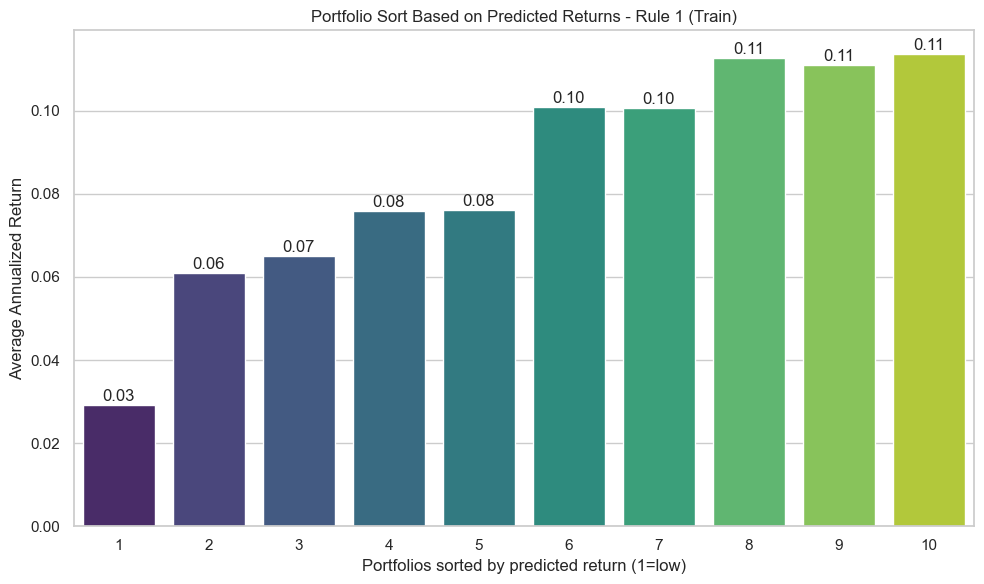


=== Prediction Rule 1: Portfolio Sort - Training Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.002431           0.029173
1   2  0.005087           0.061042
2   3  0.005425           0.065101
3   4  0.006316           0.075796
4   5  0.006339           0.076071
5   6  0.008416           0.100996
6   7  0.008390           0.100684
7   8  0.009384           0.112613
8   9  0.009249           0.110985
9  10  0.009474           0.113689


/var/folders/f7/h7gd1wy16ms_67dx94ws__x40000gn/T/ipykernel_31907/1842511641.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')


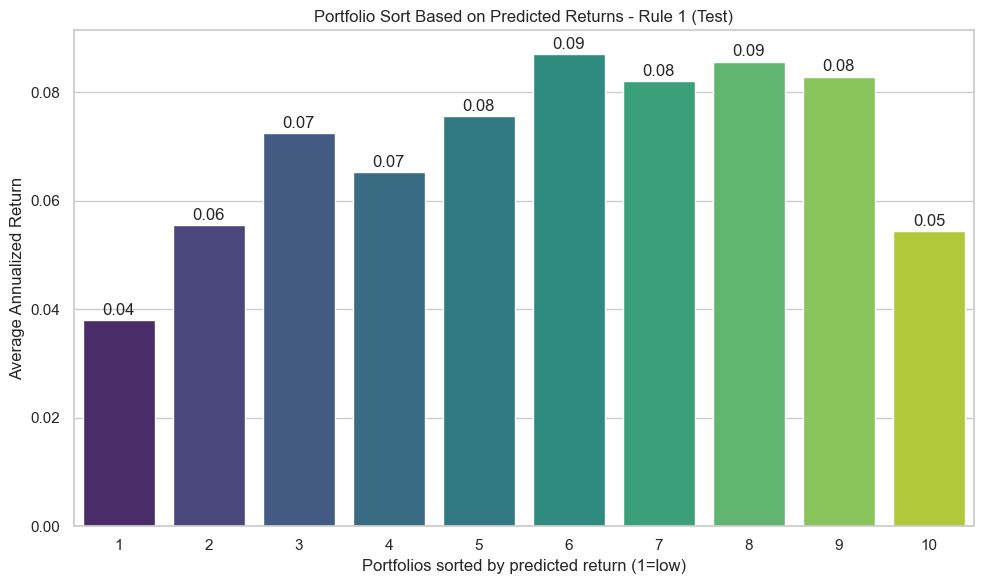


=== Prediction Rule 1: Portfolio Sort - Test Data ===
   pf    pf_ret  pf_ret_annualized
0   1  0.003163           0.037959
1   2  0.004622           0.055468
2   3  0.006035           0.072424
3   4  0.005442           0.065301
4   5  0.006300           0.075596
5   6  0.007255           0.087059
6   7  0.006842           0.082098
7   8  0.007140           0.085677
8   9  0.006903           0.082842
9  10  0.004535           0.054425

=== Prediction Rule 1: Long-Short Portfolio - Training Data ===
Annualized Mean Return: 0.0874
Annualized Standard Deviation: 0.1724
Sharpe Ratio: 0.3911

=== Prediction Rule 1: Long-Short Portfolio - Test Data ===
Annualized Mean Return: 0.0137
Annualized Standard Deviation: 0.2065
Sharpe Ratio: -0.0303


In [97]:
# ----- Prediction Rule 1: OLS Regression on Train Data -----

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 1: Define Explanatory Variables for Rule 1 ---
# Assuming 'r_lg1' and 'me_lg1' are the explanatory variables for Rule 1
explanatory_vars_rule1 = ['r_lg1', 'me_lg1']

# --- Step 2: Aggregate explanatory variables by 'eom' ---
aggregated_train_1 = train_clean.groupby('eom')[explanatory_vars_rule1].mean().reset_index()
# Merge with 'difference_series_diff' for training data
aggregated_train_1 = pd.merge(aggregated_train_1, difference_series_diff, on='eom')

# --- Step 3: Define and Fit OLS Model using smf.ols ---
formula_rule1 = 'difference_series_diff ~ ' + ' + '.join(explanatory_vars_rule1)
ols_model_rule1 = smf.ols(formula=formula_rule1, data=aggregated_train_1).fit()

# --- Step 4: Print Regression Results ---
print('\n=== OLS Regression Results: Prediction Rule 1 ===')
print(ols_model_rule1.summary())

# ----- Portfolio Sort Function (Same as before) -----
def pf_sort(data, model=None, beta=None, intercept=0, explanatory_vars=[], n_pfs=10, annualize=True, save_path=None, title=""):
    if model is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = model.predict(X)
    elif beta is not None:
        X = sm.add_constant(data[explanatory_vars])
        data = data.copy()
        data['pred'] = np.dot(X, beta) + intercept
    else:
        raise ValueError("Either model or beta must be provided.")
    
    # Assign to portfolios based on prediction percentiles
    data['pred_percentile'] = data['pred'].rank(pct=True)
    data['pf'] = np.ceil(data['pred_percentile'] * n_pfs).astype(int)
    data['pf'] = data['pf'].clip(upper=n_pfs)
    
    # Compute equal-weighted return of each portfolio in month t
    pfs = data.groupby(['pf', 'eom'])['r'].mean().reset_index(name='pf_ret')
    
    # Compute average return of each portfolio
    stock_summary = pfs.groupby('pf')['pf_ret'].mean().reset_index()
    if annualize:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret'] * 12
    else:
        stock_summary['pf_ret_annualized'] = stock_summary['pf_ret']
    
    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10,6))
    sns.barplot(x='pf', y='pf_ret_annualized', data=stock_summary, palette='viridis')
    for index, row in stock_summary.iterrows():
        plt.text(row.pf - 1, row.pf_ret_annualized + 0.001, f"{row.pf_ret_annualized:.2f}", ha='center')
    plt.xlabel('Portfolios sorted by predicted return (1=low)')
    plt.ylabel('Average Annualized Return')
    plt.title(title if title else 'Portfolio Sort Based on Predicted Returns')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()
    
    return stock_summary

# ----- Long-Short Portfolio Function (Same as before) -----
def create_long_short_portfolio(data, model, explanatory_vars, n_pfs=10, n_long=1, n_short=1, risk_free_rate=0.02, annualize=True):
    # Predict returns
    X = sm.add_constant(data[explanatory_vars])
    data = data.copy()
    data['pred'] = model.predict(X)
    
    # Assign to portfolios based on prediction percentiles
    data['pred_percentile'] = data['pred'].rank(pct=True)
    data['pf'] = np.ceil(data['pred_percentile'] * n_pfs).astype(int)
    data['pf'] = data['pf'].clip(upper=n_pfs)
    
    # Compute equal-weighted returns of portfolios over time
    pfs = data.groupby(['pf', 'eom'])['r'].mean().reset_index(name='pf_ret')
    
    # Define portfolios to long and short
    long_pfs = list(range(n_pfs - n_long + 1, n_pfs + 1))
    short_pfs = list(range(1, n_short + 1))
    
    # Extract returns for long and short portfolios
    long_returns = pfs[pfs['pf'].isin(long_pfs)].groupby('eom')['pf_ret'].mean().reset_index(name='long_return')
    short_returns = pfs[pfs['pf'].isin(short_pfs)].groupby('eom')['pf_ret'].mean().reset_index(name='short_return')
    
    # Merge long and short returns
    long_short = pd.merge(long_returns, short_returns, on='eom', how='inner')
    
    # Compute long-short portfolio returns
    long_short['long_short_return'] = long_short['long_return'] - long_short['short_return']
    
    # Calculate statistics
    if annualize:
        mean_return = long_short['long_short_return'].mean() * 12
        std_return = long_short['long_short_return'].std() * np.sqrt(12)
    else:
        mean_return = long_short['long_short_return'].mean()
        std_return = long_short['long_short_return'].std()
    
    # Calculate Sharpe Ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    
    return mean_return, std_return, sharpe_ratio

# ----- Prediction Rule 1: Portfolio Sort on Training Data -----
train_summary_rule1 = pf_sort(
    data=train_clean,
    model=ols_model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=10,  # Number of portfolios
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 1 (Train)"
)

# Print summary
print("\n=== Prediction Rule 1: Portfolio Sort - Training Data ===")
print(train_summary_rule1)

# ----- Prediction Rule 1: Portfolio Sort on Test Data -----
# Aggregate explanatory variables by 'eom' for test data
aggregated_test_1 = test_clean.groupby('eom')[explanatory_vars_rule1].mean().reset_index()
# Merge with 'difference_series_diff_test_df' for test data
aggregated_test_1 = pd.merge(aggregated_test_1, difference_series_diff_test_df, on='eom')

test_summary_rule1 = pf_sort(
    data=test_clean,
    model=ols_model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=10,  # Number of portfolios
    annualize=True,
    title="Portfolio Sort Based on Predicted Returns - Rule 1 (Test)"
)

# Print summary
print("\n=== Prediction Rule 1: Portfolio Sort - Test Data ===")
print(test_summary_rule1)

# ----- Long-Short Portfolio: Long Top 1 Quintile and Short Bottom 1 Quintile -----
# Parameters
n_pfs = 10          # Total number of portfolios
n_long = 1          # Number of top portfolios to long
n_short = 1         # Number of bottom portfolios to short
risk_free_rate = 0.02  # Annual risk-free rate

# ----- Long-Short Portfolio on Training Data -----
mean_train, std_train, sharpe_train = create_long_short_portfolio(
    data=train_clean,
    model=ols_model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=n_pfs,
    n_long=n_long,
    n_short=n_short,
    risk_free_rate=risk_free_rate,
    annualize=True
)

print("\n=== Prediction Rule 1: Long-Short Portfolio - Training Data ===")
print(f"Annualized Mean Return: {mean_train:.4f}")
print(f"Annualized Standard Deviation: {std_train:.4f}")
print(f"Sharpe Ratio: {sharpe_train:.4f}")

# ----- Long-Short Portfolio on Test Data -----
mean_test, std_test, sharpe_test = create_long_short_portfolio(
    data=test_clean,
    model=ols_model_rule1,
    explanatory_vars=explanatory_vars_rule1,
    n_pfs=n_pfs,
    n_long=n_long,
    n_short=n_short,
    risk_free_rate=risk_free_rate,
    annualize=True
)

print("\n=== Prediction Rule 1: Long-Short Portfolio - Test Data ===")
print(f"Annualized Mean Return: {mean_test:.4f}")
print(f"Annualized Standard Deviation: {std_test:.4f}")
print(f"Sharpe Ratio: {sharpe_test:.4f}")
